In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from io import BytesIO
from PIL import Image
#import cv2
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization,GlobalAveragePooling3D,GlobalMaxPool3D
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:

for image in os.listdir('images'):
    name=str(image).replace(".png","")
    name=name.split('_')
    folder,subfolder,filename=name[0],name[1],name[2]
    pre_path=f'D:\data\gravitational wave\images\{image}'
    pra_path=f'D:\data\gravitational wave\{folder}\{subfolder}\{filename}.png'
    shutil.move(pre_path,pra_path)
print('moving complete')

moving complete


In [3]:
train_dir = 'train'
val_dir = 'validation'
test_dir = 'test'

In [4]:
# Show total data in folder
for folder in os.listdir():
  if os.path.isdir(folder):
    for dirpath, dirnames, filenames in os.walk(folder):
      print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

0 folder and 0 images in images
2 folder and 0 images in test
0 folder and 100 images in test\grav
0 folder and 100 images in test\nongrav
2 folder and 0 images in train
0 folder and 400 images in train\grav
0 folder and 400 images in train\nongrav
2 folder and 0 images in validation
0 folder and 100 images in validation\grav
0 folder and 100 images in validation\nongrav
0 folder and 10 images in __results___files


Image Shape : (760, 760, 3)


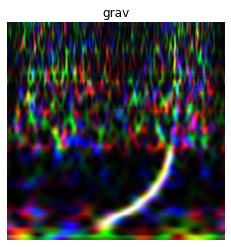

Image Shape : (760, 760, 3)


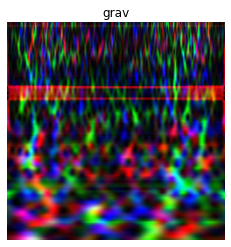

Image Shape : (760, 760, 3)


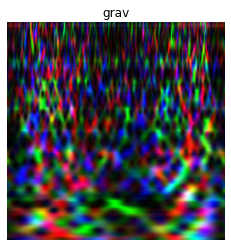

Image Shape : (760, 760, 3)


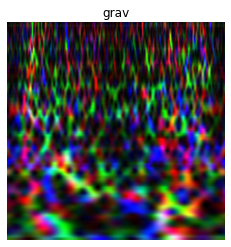

Image Shape : (760, 760, 3)


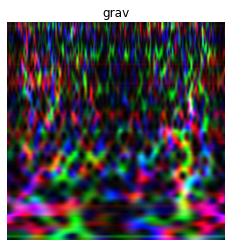

In [5]:
# Function for showing image sources
def view_random_image(target_dir, target_class):
    target_folder = target_dir+"/" + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

# Show image for classes 'Nitrogen(N)'
for i in range(1,6):
    img_n = view_random_image(target_dir='train', target_class='grav')

Image Shape : (760, 760, 3)


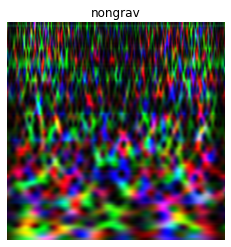

Image Shape : (760, 760, 3)


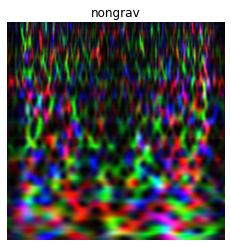

Image Shape : (760, 760, 3)


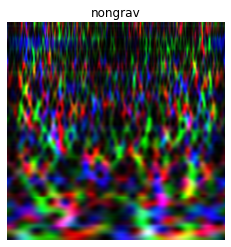

Image Shape : (760, 760, 3)


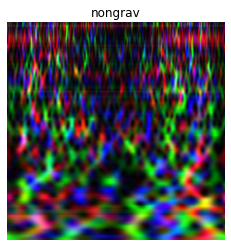

Image Shape : (760, 760, 3)


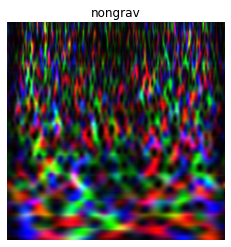

In [6]:
# Show image for classes 'Phosphorus(P)'
for i in range(1,6):
    img_n = view_random_image(target_dir='train', target_class='nongrav')

In [7]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [8]:
# flow from directory using datagen (Pipeline)
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               shuffle=False,
                                               seed=46)

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [9]:
# Check class_indices
label_indices = train_data.class_indices
label_indices

{'grav': 0, 'nongrav': 1}

In [10]:
# Set labels
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [11]:
# Check shapes of labels
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (800,)
val_y.shape:  (200,)
test_y.shape:  (200,)


# Modelling

In [12]:
# Model Definition
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

In [34]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('grav') and 1 for the other ('nongrav')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [35]:
# Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 111, 111, 128)    0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 111, 111, 128)     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 32)      36896     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 54, 54, 32)       

In [93]:
# Plot of Model Summary
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [15]:
from tensorflow.keras.optimizers import RMSprop
# compile model
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# train model
initial_epochs = 15
history = model.fit(train_data, epochs=initial_epochs, validation_data=valid_data)

Epoch 1/15
50/50 [==============================] - 248s 4s/step - loss: 0.7355 - accuracy: 0.4737 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/15
50/50 [==============================] - 126s 3s/step - loss: 0.6942 - accuracy: 0.4963 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/15
50/50 [==============================] - 116s 2s/step - loss: 0.6944 - accuracy: 0.4700 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/15
50/50 [==============================] - 113s 2s/step - loss: 0.6998 - accuracy: 0.5250 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 5/15
50/50 [==============================] - 118s 2s/step - loss: 0.6941 - accuracy: 0.4963 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/15
50/50 [==============================] - 118s 2s/step - loss: 0.6937 - accuracy: 0.4963 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/15
50/50 [==============================] - 120s 2s/step - loss: 0.6937 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 8/15
50

In [16]:

# Function for showing plot of model
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()



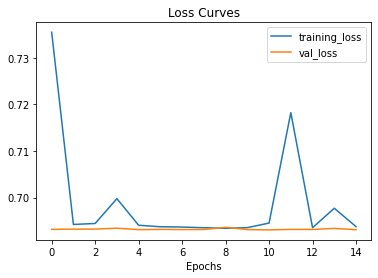

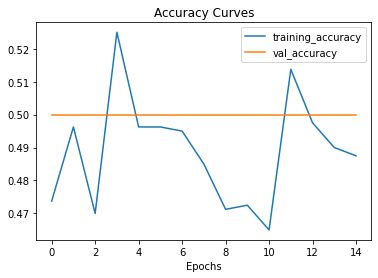

In [17]:
# Show the plot of model
plot_loss_curves(history)

In [18]:
# Evaluation
model.evaluate(valid_data)

13/13 [==============================] - 7s 508ms/step - loss: 0.6931 - accuracy: 0.5000


[0.6930975914001465, 0.5]

testing for grav image

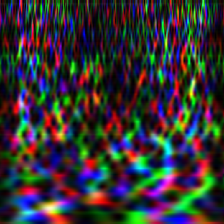

In [31]:
# Convert Image and Prediction

n1_arr = tf.keras.preprocessing.image.img_to_array(n1)
n1_arr = np.array([n1_arr])  # Convert single image to a batch.
n1_arr = n1_arr.astype('float32') / 255
n1_pred = model.predict(n1_arr).argmax(axis=1)
n1_pred_res = []
for i,j in label_indices.items():
  if n1_pred==j:
    n1_pred_res.append(i)

n1_pred_res

['grav']